In [2]:
print("Hello world")

Hello world


In [3]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm  # Import tqdm
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
class SemArtDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform
        self.image_files = dataframe['IMAGE_FILE'].values
        self.labels = dataframe['TYPE'].values
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.base_path, img_name)
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats/defaults
    #Add other augmentations later
])


In [7]:
# Load CSV files
train_df = pd.read_csv("data/semart_train.csv", sep="\t", encoding="ISO-8859-1")
test_df = pd.read_csv("data/semart_test.csv", sep="\t", encoding="ISO-8859-1")
val_df = pd.read_csv("data/semart_val.csv", sep="\t", encoding="ISO-8859-1")

# Hard-code the classes to focus on: 'religious', 'portrait', 'landscape',"still-life","mythological'
#We need to recude the scope
target_classes = ['religious', 'portrait', 'landscape',"still-life","mythological"]

# Filter the DataFrames to include only these three classes
train_df = train_df[train_df['TYPE'].isin(target_classes)]
val_df = val_df[val_df['TYPE'].isin(target_classes)]
test_df = test_df[test_df['TYPE'].isin(target_classes)]

original_class_labels = train_df['TYPE'].unique()




In [8]:
# Take the first 2 images?? Use the same images for the val set??
train_df = train_df.head(2)
test_df = train_df.copy()
val_df = train_df.copy()

In [9]:
# Label encoding
le = LabelEncoder()
train_df['TYPE'] = le.fit_transform(train_df['TYPE'])
test_df['TYPE'] = le.transform(test_df['TYPE'])
val_df['TYPE'] = le.transform(val_df['TYPE'])

encoded_to_original = dict(zip(range(len(le.classes_)), le.classes_))

# Load dataset
base_path = 'processed_imagesV2/'
train_dataset = SemArtDataset(train_df, base_path, transform=transform)
val_dataset = SemArtDataset(val_df, base_path, transform=transform)
test_dataset = SemArtDataset(test_df, base_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
def overfit_test(train_loader, val_loader, learning_rate=1e-4, amount_of_nodes=4096, plot_epoch_training=False):
    """
    Conducts an overfitting test on a small dataset to validate the training process.
    (...)

    # When you have a network, train your model with 2 images. The loss should approach 0.0. We expect the model to overfit.

    # It may take time, and the loss will gradually approach 0.0.

    # The model should overfit on at least 1 sample, but the goal is not to overfit.

    Args:
        train_loader: Training dataset loader 
        val_loader: Validation dataset loader 
        amount_of_nodes: Number of nodes at the end default 4096.
        learning_rate: Learning rate for the optimizer.
        plot_epoch_training: Boolean flag to enable or disable progress bars during training/validation.

    Returns:
        image: 
    """
    model = models.vgg16(pretrained=True)

    for param in model.features.parameters():
        param.requires_grad = False

    num_classes = len(np.unique(train_df['TYPE']))  

    # Default classifier (but we want to change the amount of nodes)
    new_classifier = nn.Sequential(
        nn.Linear(25088, amount_of_nodes),  # First fully connected layer
        nn.ReLU(inplace=True),  # Activation function
        nn.Dropout(p=0.5),      # Dropout layer
        nn.Linear(amount_of_nodes, amount_of_nodes),  # Second fully connected layer
        nn.ReLU(inplace=True),  # Activation function
        nn.Dropout(p=0.5),      # Dropout layer
        nn.Linear(amount_of_nodes, num_classes)   # Output layer (for num_classes classes)
    )

    # Replace the original classifier
    model.classifier = new_classifier

    # Move model to device (GPU or CPU)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) 

    num_epochs = 10
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_validation_loss = np.inf

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Training with or without progress bar
        if plot_epoch_training:
            # Wrap the train_loader with tqdm for progress bar
            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as progress_bar:
                for inputs, labels in progress_bar:
                    inputs, labels = inputs.to(device), labels.to(device).long()  # Cast labels to torch.long

                    # Zero the gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()

                    # Track loss and accuracy
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct_preds += (predicted == labels).sum().item()
                    total_preds += labels.size(0)
        else:
            # Training without tqdm progress bar
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()  # Cast labels to torch.long

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        # Calculate training loss and accuracy
        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_accuracy = correct_preds / total_preds
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)

        if plot_epoch_training:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            if plot_epoch_training:
                with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch") as val_bar:
                    for inputs, labels in val_bar:
                        inputs, labels = inputs.to(device), labels.to(device).long()

                        # Forward pass
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        # Track loss and accuracy
                        val_running_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        val_correct_preds += (predicted == labels).sum().item()
                        val_total_preds += labels.size(0)

                        # Update validation progress bar
                        val_bar.set_postfix(loss=val_running_loss / (val_bar.n + 1), accuracy=val_correct_preds / val_total_preds)
            else:
                # Validation without tqdm progress bar
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device).long()

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Track loss and accuracy
                    val_running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_preds += (predicted == labels).sum().item()
                    val_total_preds += labels.size(0)

        # Calculate validation loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = val_correct_preds / val_total_preds
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        # Save the best model based on validation loss
        if val_epoch_loss < best_validation_loss:
            #print("New best model")
            best_validation_loss = val_epoch_loss
            #torch.save(model, f'trainedmodels\\{naam}.pth')

    # Plot training and validation loss/accuracy
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss (lr: {learning_rate}) {amount_of_nodes}")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy (lr: {learning_rate}) {amount_of_nodes} ")
    plt.legend()

    plt.tight_layout()

    # Save figure if needed
    #plt.savefig(f"trainedmodels\\{naam}.png", dpi=300)

    plt.show()


d:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


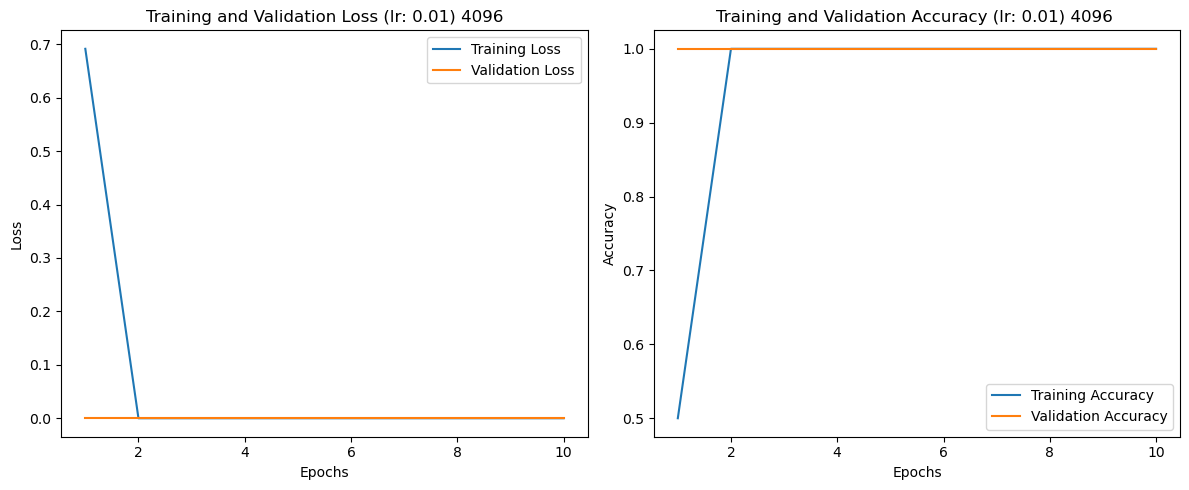

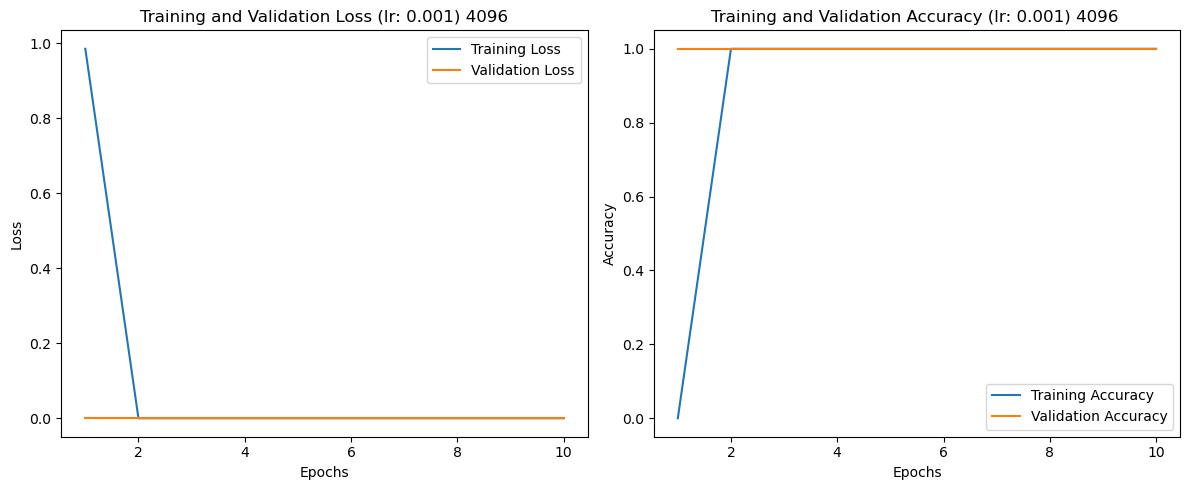

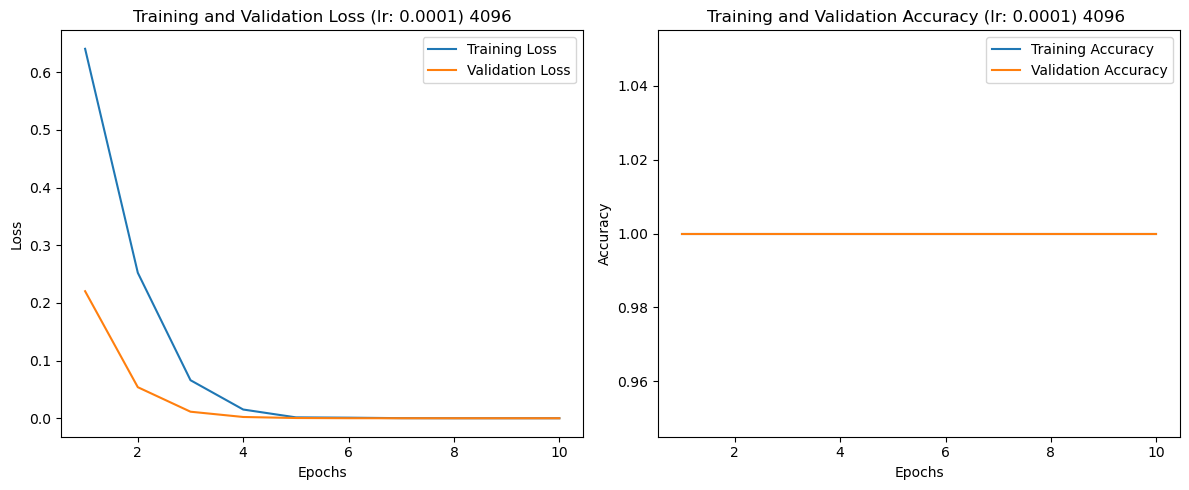

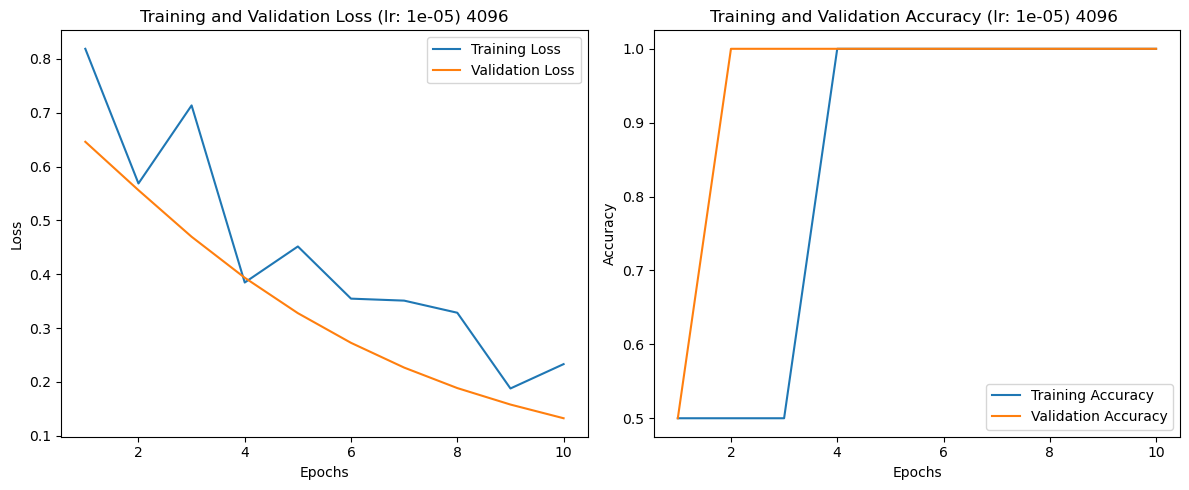

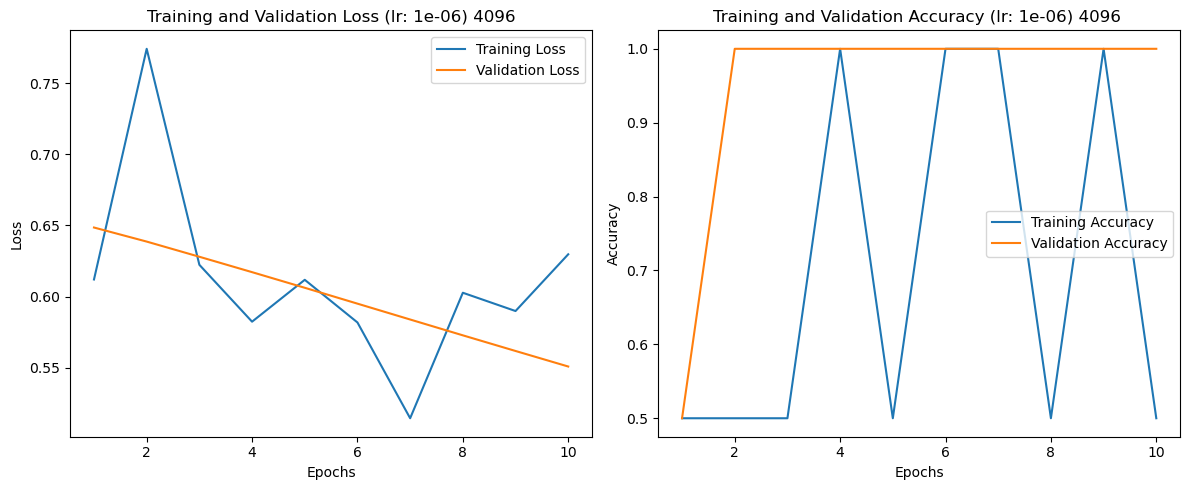

In [19]:
overfit_test(train_loader,val_loader,1e-2, 4096)
overfit_test(train_loader,val_loader,1e-3, 4096)
overfit_test(train_loader,val_loader,1e-4, 4096)
overfit_test(train_loader,val_loader,1e-5, 4096)
overfit_test(train_loader,val_loader,1e-6, 4096)

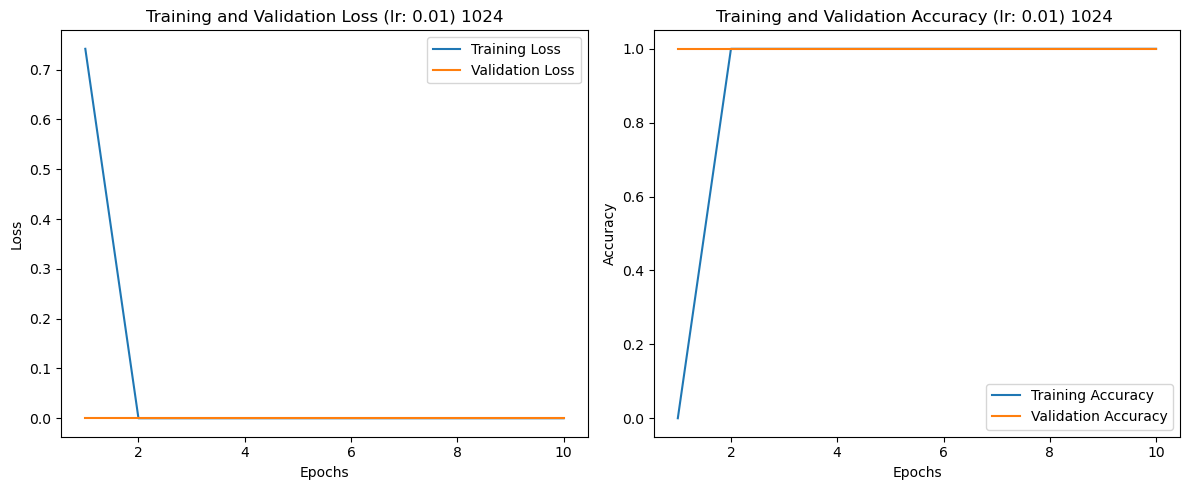

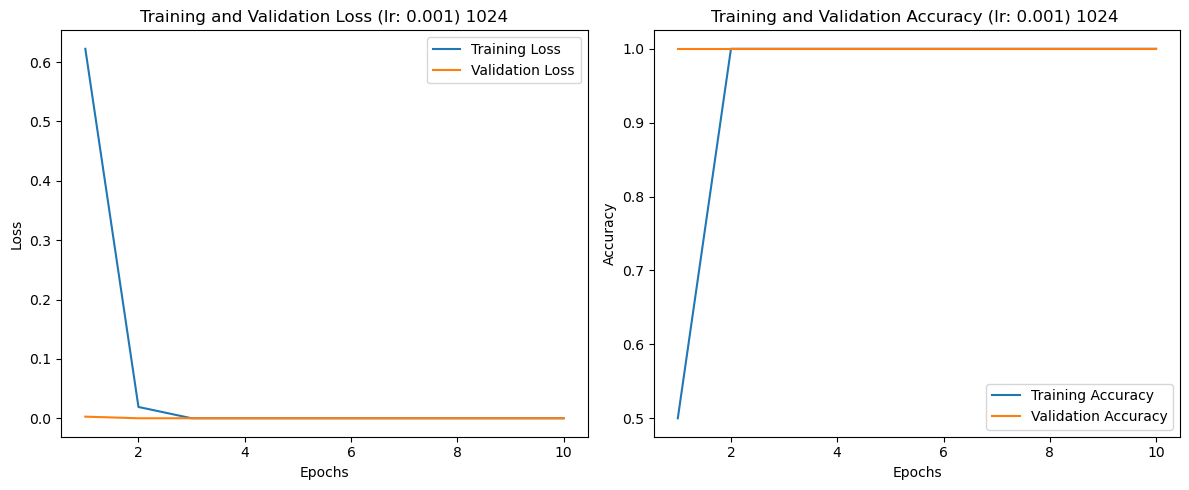

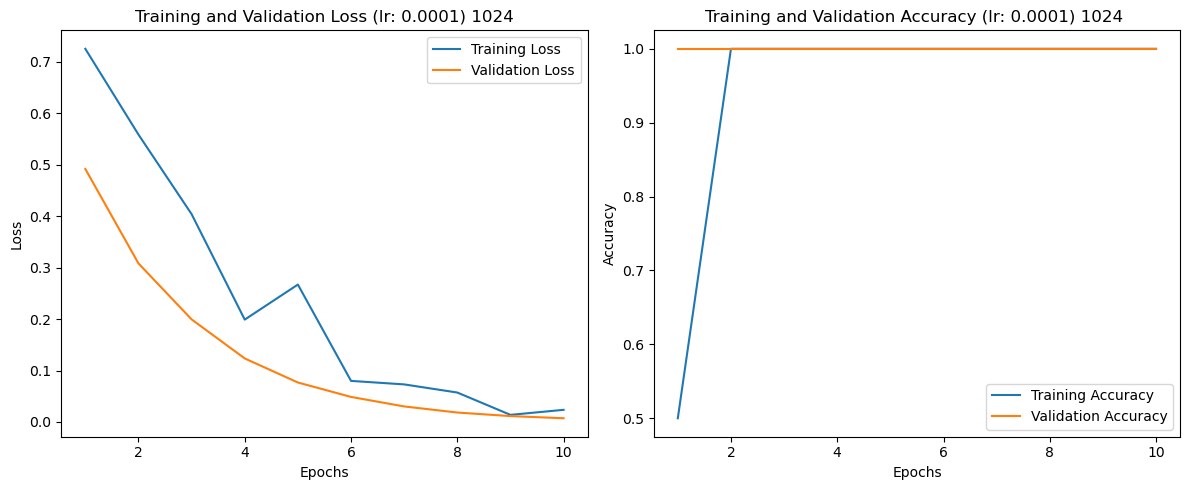

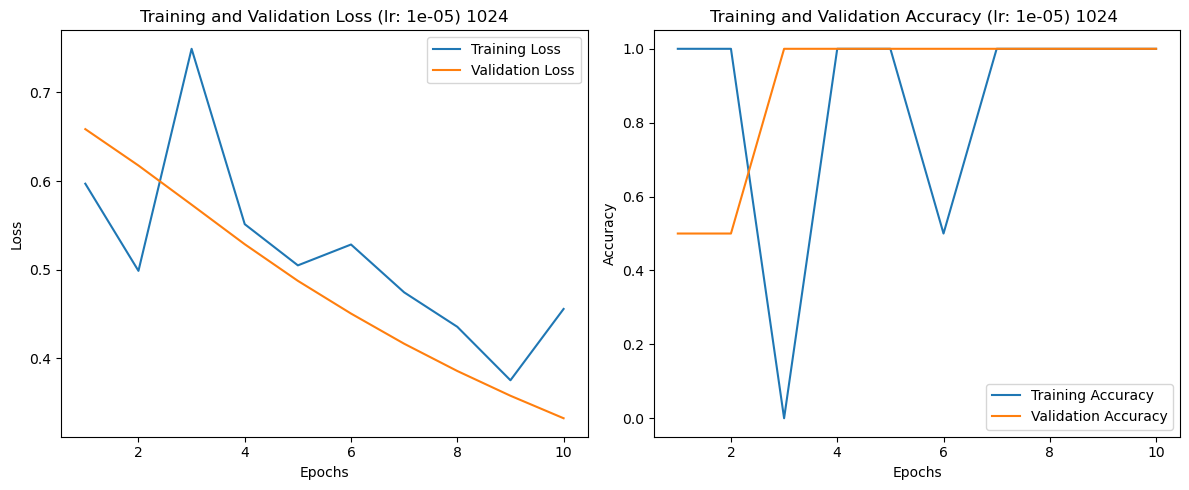

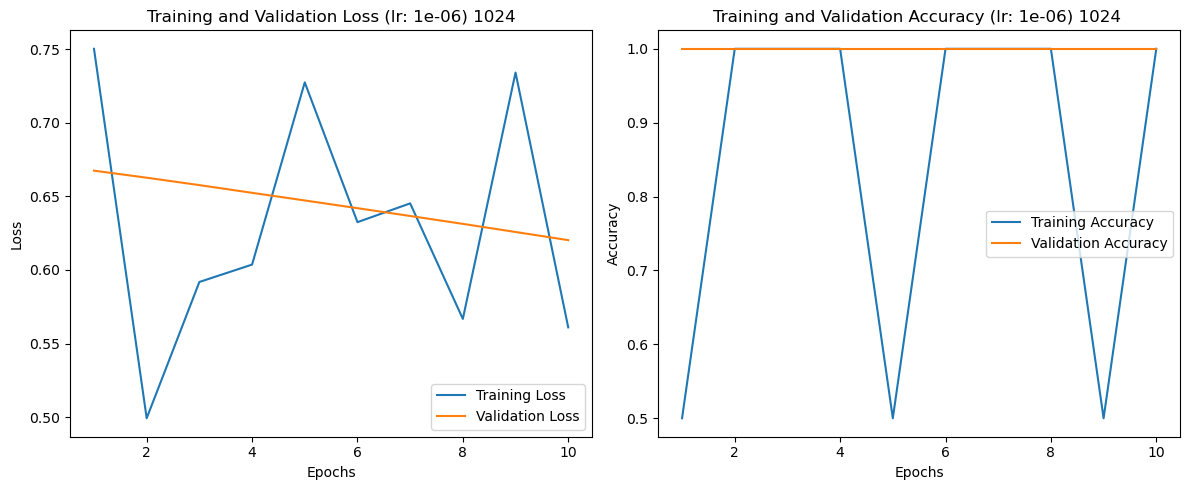

In [20]:
overfit_test(train_loader,val_loader,1e-2,1024)
overfit_test(train_loader,val_loader,1e-3,1024)
overfit_test(train_loader,val_loader,1e-4,1024)
overfit_test(train_loader,val_loader,1e-5,1024)
overfit_test(train_loader,val_loader,1e-6,1024)

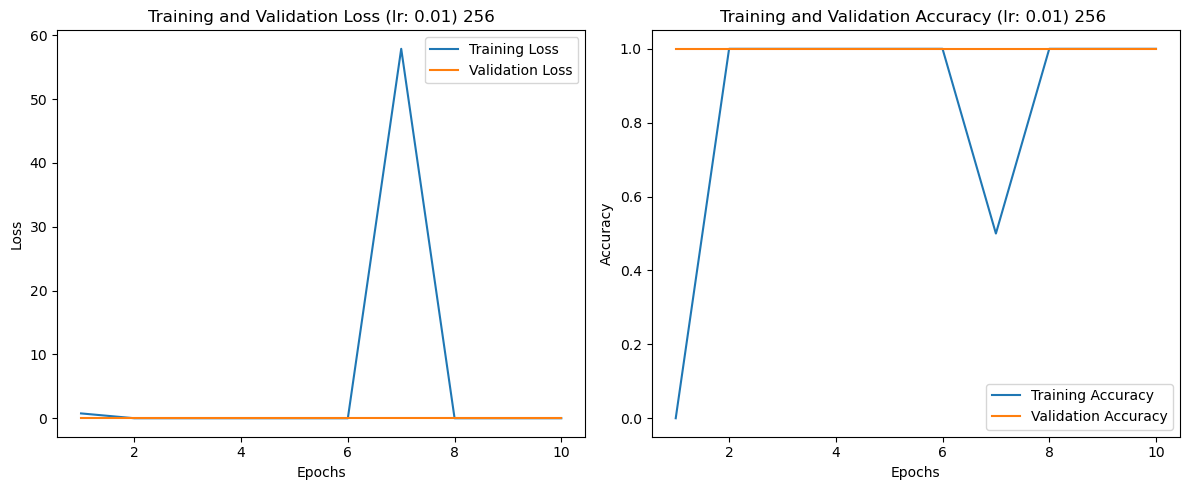

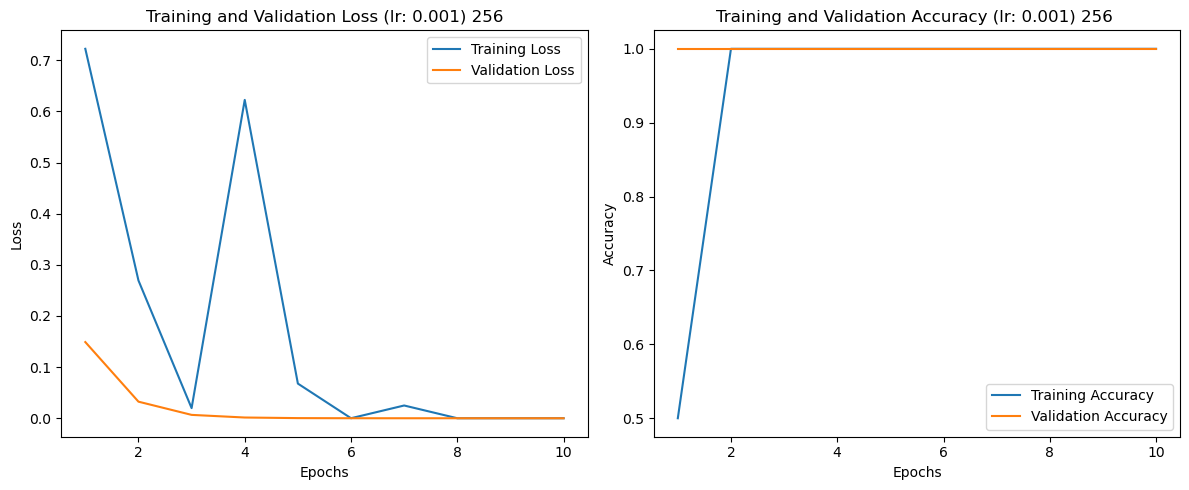

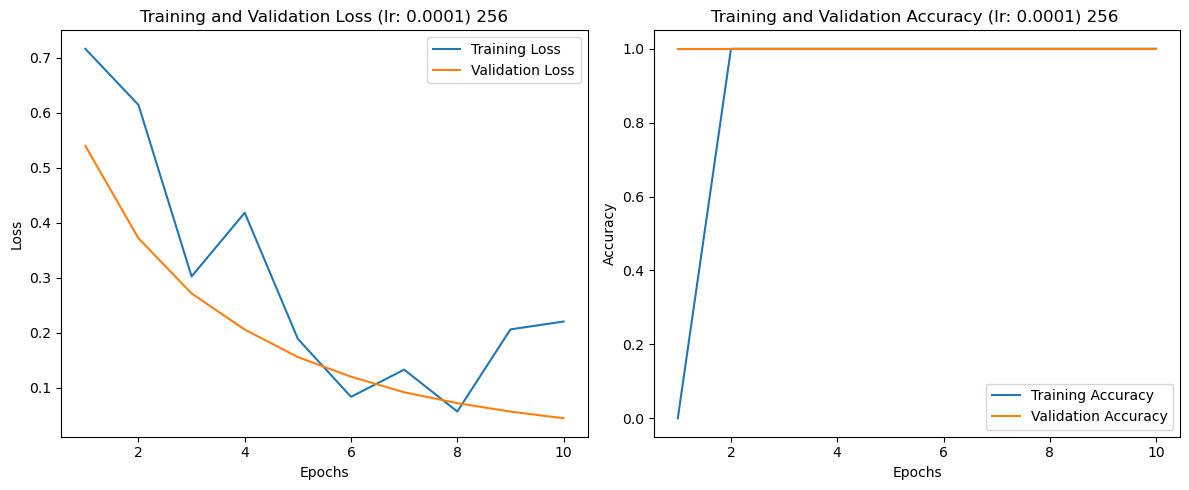

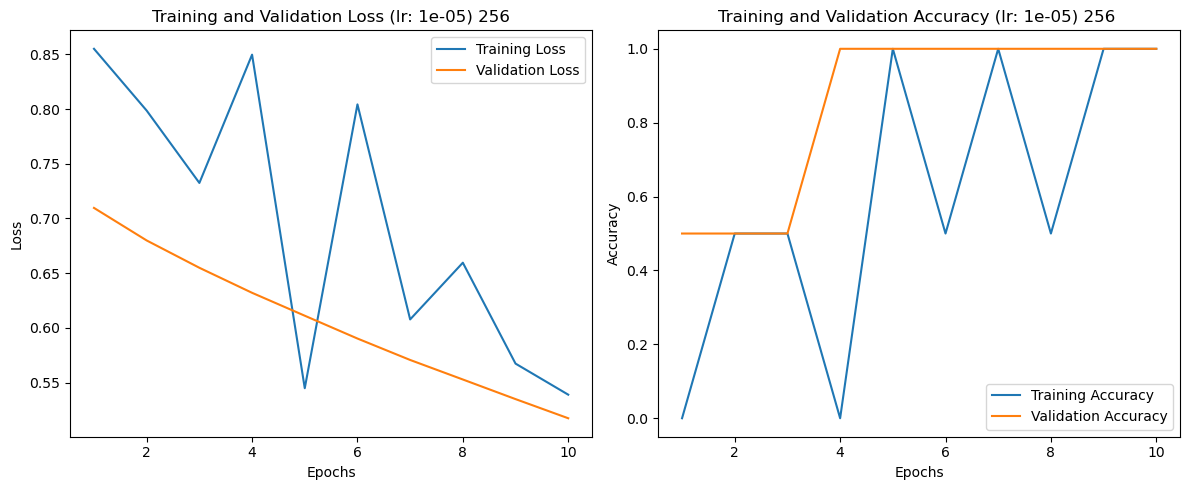

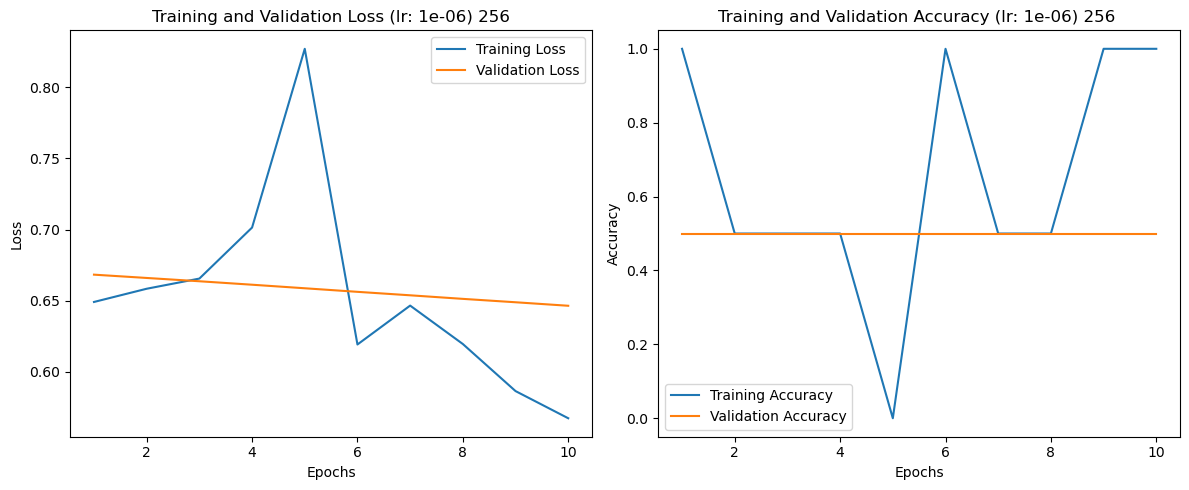

In [21]:
overfit_test(train_loader,val_loader,1e-2,256)
overfit_test(train_loader,val_loader,1e-3,256)
overfit_test(train_loader,val_loader,1e-4,256)
overfit_test(train_loader,val_loader,1e-5,256)
overfit_test(train_loader,val_loader,1e-6,256)

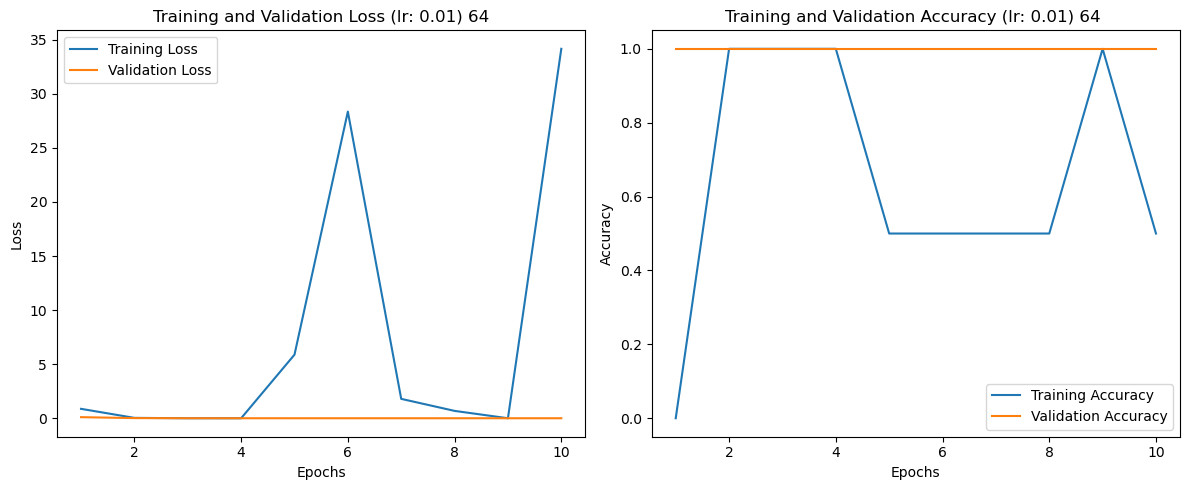

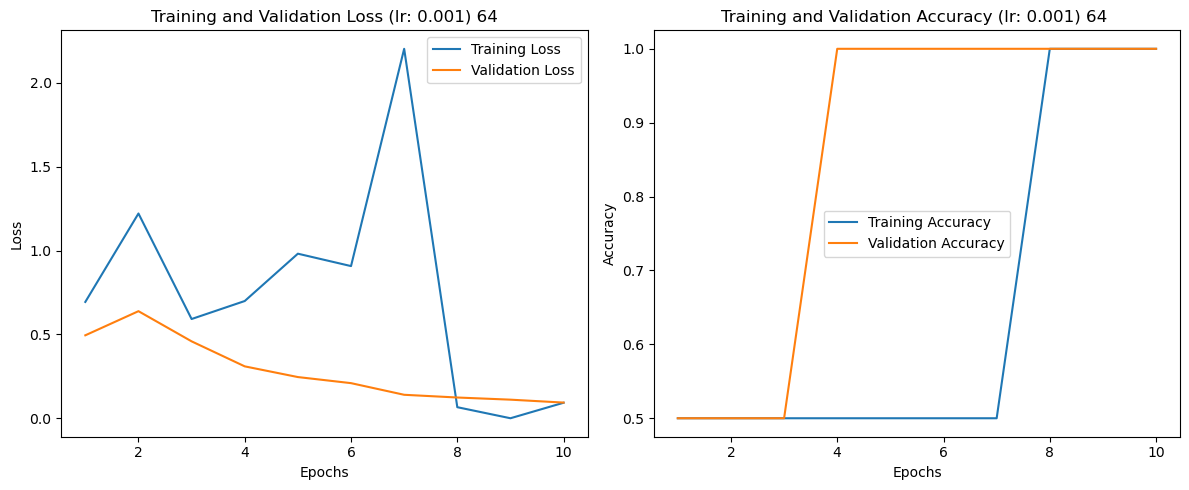

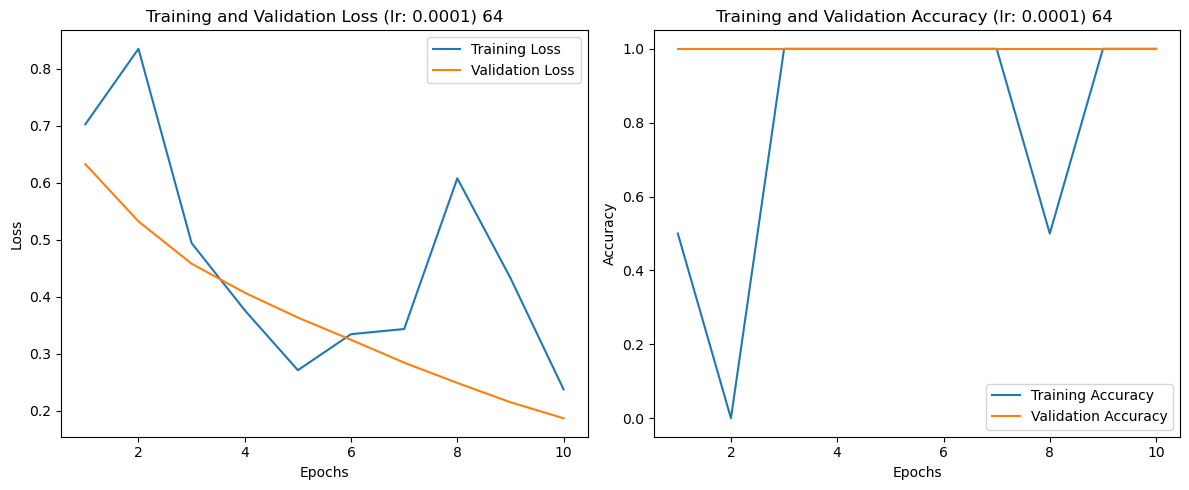

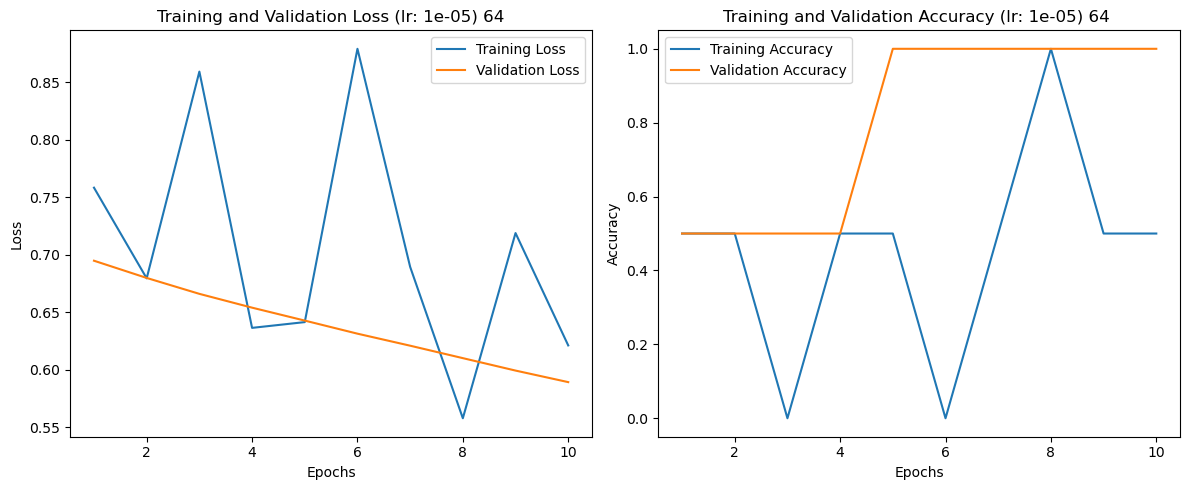

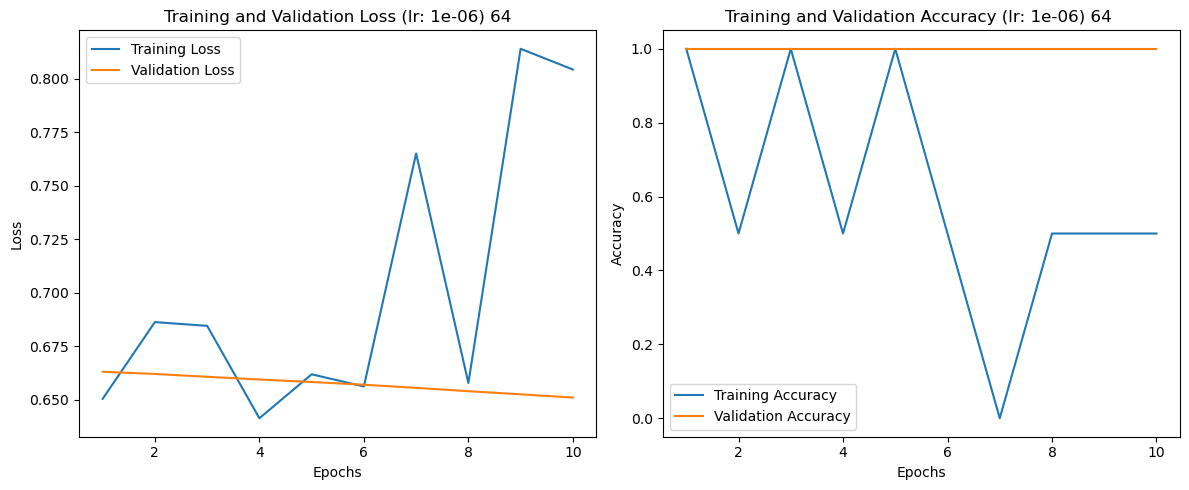

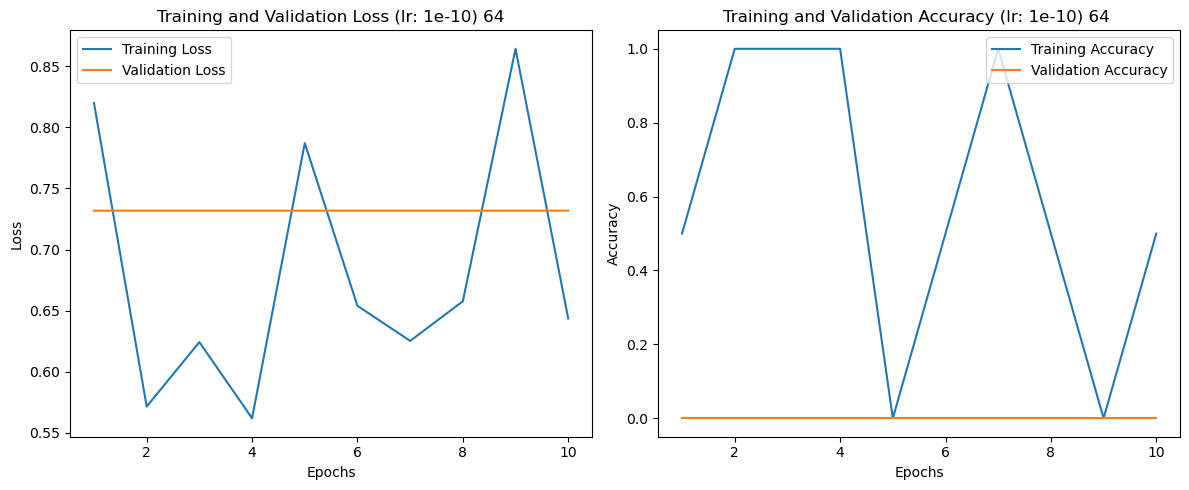

In [ ]:
overfit_test(train_loader,val_loader,1e-2,64)
overfit_test(train_loader,val_loader,1e-3,64)
overfit_test(train_loader,val_loader,1e-4,64)
overfit_test(train_loader,val_loader,1e-5,64)
overfit_test(train_loader,val_loader,1e-6,64)